In [1]:
!gdown --id 1du67TH9kjJWE5TPhRBfZjXNZbPMeQclO

Downloading...
From: https://drive.google.com/uc?id=1du67TH9kjJWE5TPhRBfZjXNZbPMeQclO
To: /content/Flickr8k_Dataset.zip
1.12GB [00:12, 89.8MB/s]


In [2]:
!gdown --id 1sbokp-DGKcVhihdVmzzk2PoSmwOdpGx_

Downloading...
From: https://drive.google.com/uc?id=1sbokp-DGKcVhihdVmzzk2PoSmwOdpGx_
To: /content/Flickr8k_text.zip
2.34MB [00:00, 73.6MB/s]


In [3]:
!mkdir Data

In [4]:
!mkdir Data/Images

In [5]:
!mkdir Data/Flickr_TextData

In [6]:
!mkdir model_weights

In [7]:
!unzip

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [8]:
!unzip -j Flickr8k_Dataset.zip -d Data/Images/

Streaming output truncated to the last 5000 lines.
  inflating: Data/Images/._342872408_04a2832a1b.jpg  
  inflating: Data/Images/3429142249_d09a32e291.jpg  
  inflating: Data/Images/._3429142249_d09a32e291.jpg  
  inflating: Data/Images/3429194423_98e911a101.jpg  
  inflating: Data/Images/._3429194423_98e911a101.jpg  
  inflating: Data/Images/3429351222_17ae744daf.jpg  
  inflating: Data/Images/._3429351222_17ae744daf.jpg  
  inflating: Data/Images/3429351964_531de1bf16.jpg  
  inflating: Data/Images/._3429351964_531de1bf16.jpg  
  inflating: Data/Images/3429391520_930b153f94.jpg  
  inflating: Data/Images/._3429391520_930b153f94.jpg  
  inflating: Data/Images/3429465163_fb8ac7ce7f.jpg  
  inflating: Data/Images/._3429465163_fb8ac7ce7f.jpg  
  inflating: Data/Images/3429581486_4556471d1a.jpg  
  inflating: Data/Images/._3429581486_4556471d1a.jpg  
  inflating: Data/Images/3429641260_2f035c1813.jpg  
  inflating: Data/Images/._3429641260_2f035c1813.jpg  
  inflating: Data/Images/342995

In [9]:
!unzip Flickr8k_text.zip -d Data/Flickr_TextData/

Archive:  Flickr8k_text.zip
  inflating: Data/Flickr_TextData/CrowdFlowerAnnotations.txt  
  inflating: Data/Flickr_TextData/ExpertAnnotations.txt  
  inflating: Data/Flickr_TextData/Flickr8k.lemma.token.txt  
   creating: Data/Flickr_TextData/__MACOSX/
  inflating: Data/Flickr_TextData/__MACOSX/._Flickr8k.lemma.token.txt  
  inflating: Data/Flickr_TextData/Flickr8k.token.txt  
  inflating: Data/Flickr_TextData/Flickr_8k.devImages.txt  
  inflating: Data/Flickr_TextData/Flickr_8k.testImages.txt  
  inflating: Data/Flickr_TextData/Flickr_8k.trainImages.txt  
  inflating: Data/Flickr_TextData/readme.txt  


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import Sequence
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

## Data Collection

In [11]:
#Read Captions

def readTextFile(path):
  with open(path) as f:
    captions = f.read()
  return captions

In [12]:
captions = readTextFile('Data/Flickr_TextData/Flickr8k.token.txt')
captions = captions.split('\n')[:-1]

In [13]:
print(len(captions))

40460


In [14]:
captions[0].split('\t')

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [15]:
# Dictionary to map each inage to its caption

In [16]:
descriptions = {}
for x in captions:
  first, second = x.split('\t')
  img_name = first.split('.')[0]

  #if img_id is already present or not
  if descriptions.get(img_name) is None:
    descriptions[img_name] = []

  descriptions[img_name].append(second)

In [17]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

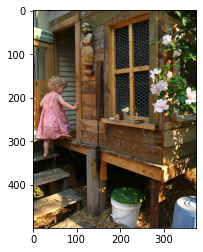

In [18]:
IMG_PATH = 'Data/Images/'
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

## Data Cleaning
- Remove Numbers
- lower()
- Punctuations....

In [19]:
def clean_text(sentence):
  sentence = sentence.lower()
  sentence = re.sub('[^a-z]+', ' ', sentence)
  sentence = sentence.split()

  sentence = [s for s in sentence if len(s)>1]
  sentence = ' '.join(sentence)
  return sentence

In [20]:
clean_text('A cat is sitting over the house # 64')

'cat is sitting over the house'

In [21]:
# Clean all captions

for key, caption_list in descriptions.items():
  for i in range(len(caption_list)):
    caption_list[i] = clean_text(caption_list[i])

In [22]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [23]:
# Write the data to a text file
with open('descriptions.txt', 'w') as f:
  f.write(str(descriptions))

## Creating Vocab

In [24]:
descriptions = None
with open('descriptions.txt') as f:
  descriptions = f.read()

json_acceptable = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable)

In [25]:
print(type(descriptions))

<class 'dict'>


In [26]:
# Vocab

vocab = set()
for key in descriptions.keys():
  [vocab.update(sentence.split()) for sentence in descriptions[key]]

print('Vocab Size : %d' %(len(vocab)))

Vocab Size : 8424


In [27]:
# Total no. of words across all sentences
total_words = []
for key in descriptions.keys():
  [total_words.append(i) for des in descriptions[key] for i in des.split()]
print('Total words %d' %(len(total_words)))

Total words 373837


In [28]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [29]:
# Filter words from the vocab acc to a threshold

In [30]:
import collections
counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [31]:
#Sort this dictionary acc to freq_cnt
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [32]:
print(len(total_words)) #vocab size

1845


## Prepare Train/Test Data

In [33]:
train_file_data = readTextFile('Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [34]:
train = [row.split('.')[0] for row in train_file_data.split('\n')[:-1]]
test = [row.split('.')[0] for row in test_file_data.split('\n')[:-1]]
print(train[0:5])

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87']


In [35]:
# Prepare descr for training data
# tweak  - Add <s> and <e> token to our training data
train_descriptions = {}
for img_id in train:
  train_descriptions[img_id] = []
  for cap in descriptions[img_id]:
    cap_to_add = 'startseq ' + cap + ' endseq'
    train_descriptions[img_id].append(cap_to_add)

In [36]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Transfer Learning
- Images --> Features
- Text --> Features

### Step-1 Image Feature Extraction Using Resnet

In [37]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

102973440/102967424 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [38]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [39]:
model_new = Model(model.input,model.layers[-2].output)

In [40]:
def preprocess_img(img):
  img = image.load_img(img,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  #Normalization
  img = preprocess_input(img)
  return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


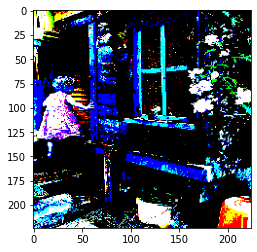

In [41]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.show()

In [42]:
print(img)

[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -49.779       20.32     ]
   [ -49.939003   -13.778999    35.32     ]
   ...
   [ 150.061      132.22101    126.

In [43]:
#Pass through trained resnet to get mX2048 image vector
def encode_image(img):
  img = preprocess_img(img)
  feature_vector = model_new.predict(img)
  feature_vector = feature_vector.reshape((-1,))
  #print(feature_vector.shape)
  return feature_vector

In [44]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535938, 0.16782546, 0.32517588, ..., 0.05107139, 0.32821164,
       1.0043377 ], dtype=float32)

In [45]:
start = time()
encoding_train = {}
    #image_id --> feature_vector from resnet50
for ix, img_id in enumerate(train):
  img_path = IMG_PATH+"/"+img_id+".jpg"
  encoding_train[img_id] = encode_image(img_path)

  if ix%100==0:
    print("Encoding(train) in Progress Time step %d" %(ix))

end_t = time()
print(["Total Time taken:", end_t-start])

Encoding(train) in Progress Time step 0
Encoding(train) in Progress Time step 100
Encoding(train) in Progress Time step 200
Encoding(train) in Progress Time step 300
Encoding(train) in Progress Time step 400
Encoding(train) in Progress Time step 500
Encoding(train) in Progress Time step 600
Encoding(train) in Progress Time step 700
Encoding(train) in Progress Time step 800
Encoding(train) in Progress Time step 900
Encoding(train) in Progress Time step 1000
Encoding(train) in Progress Time step 1100
Encoding(train) in Progress Time step 1200
Encoding(train) in Progress Time step 1300
Encoding(train) in Progress Time step 1400
Encoding(train) in Progress Time step 1500
Encoding(train) in Progress Time step 1600
Encoding(train) in Progress Time step 1700
Encoding(train) in Progress Time step 1800
Encoding(train) in Progress Time step 1900
Encoding(train) in Progress Time step 2000
Encoding(train) in Progress Time step 2100
Encoding(train) in Progress Time step 2200
Encoding(train) in Prog

In [46]:
# Store everything on disk

with open("encoded_train_features.pkl", 'wb') as f:
  pickle.dump(encoding_train, f)

In [47]:
start = time()
encoding_test = {}
    #image_id --> feature_vector from resnet50
for ix, img_id in enumerate(test):
  img_path = IMG_PATH+"/"+img_id+".jpg"
  encoding_test[img_id] = encode_image(img_path)

  if ix%100==0:
    print("Encoding(test) in Progress Time step %d" %(ix))

end_t = time()
print(["Total Time taken:", end_t-start])

Encoding(test) in Progress Time step 0
Encoding(test) in Progress Time step 100
Encoding(test) in Progress Time step 200
Encoding(test) in Progress Time step 300
Encoding(test) in Progress Time step 400
Encoding(test) in Progress Time step 500
Encoding(test) in Progress Time step 600
Encoding(test) in Progress Time step 700
Encoding(test) in Progress Time step 800
Encoding(test) in Progress Time step 900
['Total Time taken:', 48.01821279525757]


In [48]:
with open("encoded_test_features.pkl", 'wb') as f:
  pickle.dump(encoding_test, f)

## Data Preprocessing for Captions

In [49]:
#vocab
len(total_words)

1845

In [50]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
  word_to_idx[word] = i+1 
  idx_to_word[i+1] = word

In [51]:
idx_to_word[1]

'in'

In [52]:
print(word_to_idx['dog'])
print(idx_to_word[6])

6
dog


In [53]:
print(len(idx_to_word))

1845


In [54]:
#Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [55]:
max_len = 0
for key in train_descriptions.keys():
  for cap in train_descriptions[key]:
    max_len = max(max_len, len(cap.split()))

print(max_len)

35


## Data Loader(Generator)

In [56]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
  X1,X2, y = [],[],[]
  
  n =0
  while True:
    for key,desc_list in train_descriptions.items():
      n += 1
        
      photo = encoding_train[key]
      for desc in desc_list:
          
        seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
        for i in range(1,len(seq)):
          xi = seq[0:i]
          yi = seq[i]
          
          #0 denote padding word
          xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
          yi = to_categorical([yi],num_classes=vocab_size)[0]
          
          X1.append(photo)
          X2.append(xi)
          y.append(yi)
              
      if n==batch_size:
          yield {"image_input":np.array(X1),"seq_input":np.array(X2)},np.array(y).reshape(-1, vocab_size)
          X1,X2,y = [],[],[]
          n = 0


# def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
#     X1, X2, y = list(), list(), list()
#     n=0
#     # loop for ever over images
#     while 1:
#         for key, desc_list in descriptions.items():
#             n+=1
#             # retrieve the photo feature
#             photo = photos[key]
#             for desc in desc_list:
#                 # encode the sequence
#                 seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
#                 # split one sequence into multiple X, y pairs
#                 for i in range(1, len(seq)):
#                     # split into input and output pair
#                     in_seq, out_seq = seq[:i], seq[i]
#                     # pad input sequence
#                     in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
#                     # encode output sequence
#                     out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#                     # store
#                     X1.append(photo)
#                     X2.append(in_seq)
#                     y.append(out_seq)
#             # yield the batch data
#             if n==num_photos_per_batch:
#                 yield [[np.array(X1), np.array(X2)], np.array(y)]
#                 X1, X2, y = list(), list(), list()
#                 n=0

## Word Embeddings

In [80]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:08, 196MB/s] 


In [81]:
import gensim

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
embedding_index = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [89]:
embedding_index = embedding_index.wv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [90]:
len(embedding_index['apple'])

300

300

In [91]:
def get_embedding_matrix():
  emb_dim = 300
  matrix = np.zeros((vocab_size,emb_dim))
  for word,idx in word_to_idx.items():
    if word not in embedding_index.vocab:
      continue 
    embedding_vector = embedding_index[word]

    matrix[idx] = embedding_vector #map word_idx to embedding vector

  return matrix

In [92]:
embedding_matrix = get_embedding_matrix()

In [93]:
print(embedding_matrix.shape)

(1848, 300)


In [94]:
embedding_matrix[2] #the

array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281,
       -0.12060547,  0.03515625, -0.11865234,  0.04394531,  0.03015137,
       -0.05688477, -0.07617188,  0.01287842,  0.04980469, -0.08496094,
       -0.06347656,  0.00628662, -0.04321289,  0.02026367,  0.01330566,
       -0.01953125,  0.09277344, -0.171875  , -0.00131989,  0.06542969,
        0.05834961, -0.08251953,  0.0859375 , -0.00318909,  0.05859375,
       -0.03491211, -0.0123291 , -0.0480957 , -0.00302124,  0.05639648,
        0.01495361, -0.07226562, -0.05224609,  0.09667969,  0.04296875,
       -0.03540039, -0.07324219,  0.03271484, -0.06176758,  0.00787354,
        0.0035553 , -0.00878906,  0.0390625 ,  0.03833008,  0.04443359,
        0.06982422,  0.01263428, -0.00445557, -0.03320312, -0.04272461,
        0.09765625, -0.02160645, -0.0378418 ,  0.01190186, -0.01391602,
       -0.11328125,  0.09326172, -0.03930664, -0.11621094,  0.02331543,
       -0.01599121,  0.02636719,  0.10742188, -0.00466919,  0.09

## Model Architecture

In [132]:
#Images as input
input_img_features = Input(shape=(2048,),name="image_input")
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [133]:
#Captions as Input
input_captions = Input(shape=(max_len,),name="seq_input")
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=300,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [134]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [135]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          [(None, 35)]         0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 300)      554400      seq_input[0][0]                  
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 2048)         0           image_input[0][0]                
____________________________________________________________________________________________

In [136]:
#Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [137]:
optimizer = keras.optimizers.Adam(lr=0.001)

In [138]:
model.compile(loss='categorical_crossentropy',optimizer=optimizer)

## Training of Model

In [139]:
from keras import backend as K

In [140]:
epochs = 30
steps = len(train_descriptions)//number_pics_per_batch

In [141]:
def train():
  for i in range(epochs):
    if i==20:
      K.set_value(model.optimizer.learning_rate, 0.0001)
      number_pics_per_batch=6
      steps = len(train_descriptions)//number_pics_per_batch
    if i<20:
      generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,3)
      model.fit_generator(generator,epochs=1,steps_per_epoch=len(train_descriptions)//3,verbose=1)
    else:
      generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,6)
      model.fit_generator(generator,epochs=1,steps_per_epoch=len(train_descriptions)//6,verbose=1)
    model.save('model_weights/model_'+str(i)+'.h5')

In [142]:
train()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1000/1000 [==============================] - 23s 23ms/step - loss: 2.0316


In [143]:
model = load_model('model_weights/model_29.h5')

## Predictions

In [144]:
def predict_caption(photo):
  in_text = "startseq"
  for i in range(max_len):
    sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
    sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

    ypred = model.predict([photo,sequence])
    ypred = ypred.argmax() #Word with max probability
    word = idx_to_word[ypred]
    in_text += ' ' + word

    if word == 'endseq':
      break

  final_caption = in_text.split()[1:-1]
  final_caption = ' '.join(final_caption)
  return final_caption

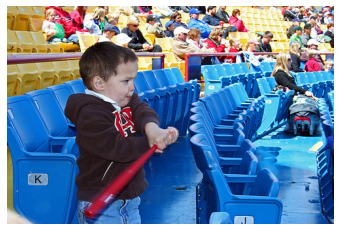

two men are standing around stadium


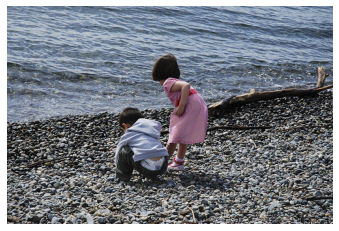

young girl in pink shirt and jeans walking on the beach


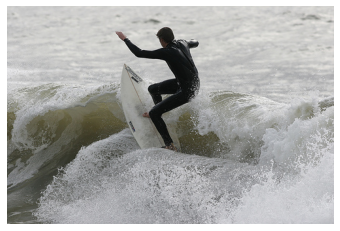

surfer in wetsuit is riding wave


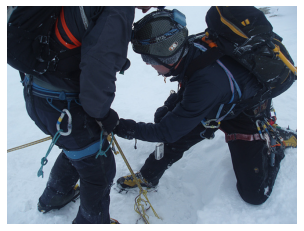

two people are in the snow making sticks


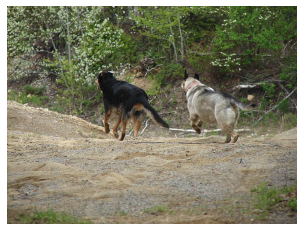

two dogs are running through the woods


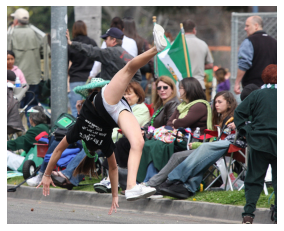

man in black shirt and cap is skating down the street


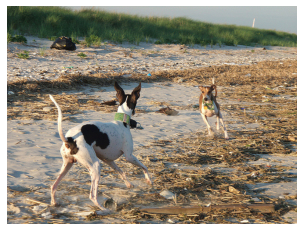

dog is running on the beach


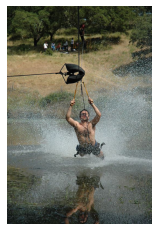

man is wakeboarding on calm water


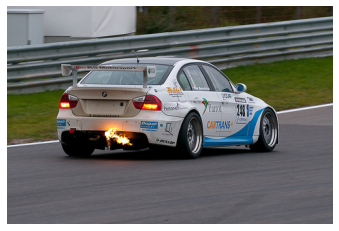

race car is driving around corner


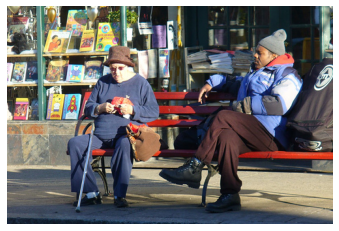

man in black shirt and tie is sitting on bench in front of white building


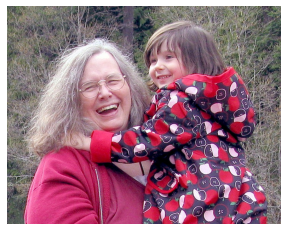

child in red coat is pointing at the plants


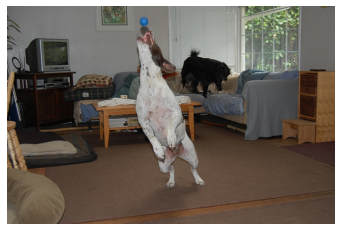

two dogs grocery in room


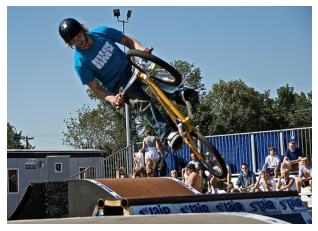

man is bending down on his bike


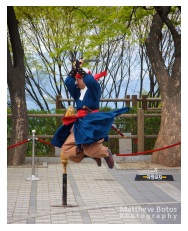

boy in red shirt is jumping onto red brick wall


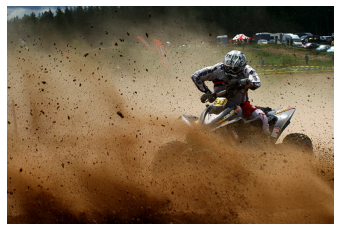

man in blue shirt is jumping over the hill of dirt bike


In [145]:
#Pick some random images and see results
for i in range(15):
  idx = np.random.randint(0,1000)
  all_img_names = list(encoding_test.keys())
  img_name = all_img_names[idx]
  photo_2048 = encoding_test[img_name].reshape((1,2048))

  i = plt.imread(IMG_PATH+'/'+img_name+'.jpg')
  caption = predict_caption(photo_2048)
  plt.imshow(i)
  plt.axis('off')
  plt.show()
  print(caption)

In [146]:
with open("word_2_idx.pkl", 'wb') as f:
  pickle.dump(word_to_idx, f)

In [147]:
with open("idx_2_word.pkl", 'wb') as f:
  pickle.dump(idx_to_word, f)

In [148]:
from google.colab import files
files.download('model_weights/model_29.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>